In [1]:
#use with environment "hydroclass"
import os
import time

import flopy
from flopy.utils.gridgen import Gridgen
from flopy.utils import GridIntersect, Raster
from flopy.utils.lgrutil import Lgr
from flopy.utils.postprocessing import get_water_table
# import pyemu

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.colors as mcolors
# package for cool and accessible colormaps (https://www.fabiocrameri.ch/colourmaps-userguide/)
from cmcrameri import cm

import pandas as pd

import geopandas as gpd
import rasterio as rio
import rasterio.plot as rioplot

# packages for generating hillshade image
import earthpy.spatial as es
import earthpy.plot as ep

# package for loading USGS stream data directly from web
from dataretrieval import nwis

In [2]:
#DIS automation
def GRIDbuilder(model_domain_shp, idomain_shp, cellsize, nlay, epsg, dem_file, 
                raster_interp_method, angle, ncpp, ncppl, build_child=True, import_tops = False):
    '''
    Creates parent and child model grids and resamples DEM rasters to modelgrid
    
    Arguments
    model_domainshp (geopandas geometry): parent model boundaries
    idomain_shp (geopandas geometry): child model boundaries, defines the idomain (noflow) of the parent model
    cellsize (float): width and height of each model cell defined for the parent model
    nlay (int): number of layers for the parent model
    epsg (int -- ex 3071): coordinate reference system -- EPSG Geodetic Parameter Dataset
    raster_interp_method (string): chose from methods = "nearest", "linear" (bilinear), "cubic" (bicubic), "max", "min", "mean", "median", and "mode"
    ncpp (int): number of child cells per parent cell
    build_child (bool): indicates that a child model grid will be built in addition to the parent. If ncpp is set this is typically the case, default = True
    
    Returns:
    pgrid (array): parent model grid
    cgrid (array): child model grid
    lgr (flopy package): contains all the package information for local grid refinement (lgr) between parent and child modesl in flopy
    iboud (array): parent model idomain (noflow boundary) coincides with child model
    topp (array2d): raster DEM resampled to pgrid
    topc (array2d): raster DEM resampled to cgrid
    
    '''
    start1 = time.time()
    bounds_arr = model_domain_shp.bounds.to_numpy()
    xmin, ymin, xmax, ymax = bounds_arr[0][0], bounds_arr[0][1], bounds_arr[0][2], bounds_arr[0][3]
    
    domain_bounds = [xmin, ymin, xmax, ymax] 
    print(domain_bounds)
    
    dx = xmax - xmin
    dy = ymax - ymin

    nlay = nlay
    nrow = np.ceil(dy / cellsize).astype(int)
    ncol = np.ceil(dx / cellsize).astype(int)
    delr = np.full((ncol,), cellsize)
    delc = np.full((nrow,), cellsize)

    # let's create a fake top and bottom for now can be replaced!!! nice
    raster = Raster.load(dem_file)
    
    top = np.full((nrow, ncol), 1)
    botm = np.full((nlay, nrow, ncol), 0)
    
    pgrid = flopy.discretization.StructuredGrid(
        delc,
        delr,
        top=top,
        botm=botm,
        nlay=nlay,
        xoff=xmin,
        yoff=ymin,
        crs=epsg,
        angrot=angle
    )
    
    #child domain = idomain
    gx = GridIntersect(pgrid)
    
    if idomain_shp is not None:
        result = gx.intersect(idomain_shp.loc[0, "geometry"])    
        ibound = np.ones((nlay, nrow, ncol))
        i, j = zip(*result.cellids)
        ibound[:, i, j] = 0
        
    elif idomain_shp is None:
        ibound = np.ones((nlay, nrow, ncol))
    
    # methods = "nearest", "linear" (bilinear), "cubic" (bicubic), "max", "min", "mean", "median", and "mode"
    if import_tops == True:
        topp = np.load(os.path.join(datapath, "topp{}.npy".format(int(cellsize))))
    else:
        print("resampling raster -- exporting to "+str(datapath))
        topp = raster.resample_to_grid(pgrid, band=raster.bands[0], method=raster_interp_method)
        np.save(os.path.join(datapath, "topp{}.npy".format(int(cellsize))), topp)
        

    
    end1 = time.time()
    print('Parent Model Grid created with resolution\n nlay: {}, nrow: {}, ncol: {}, delr: {}, delc: {}'.format(pgrid.nlay, pgrid.nrow, pgrid.ncol, pgrid.delr[0], pgrid.delc[0]))
    print('parent grid creation in ', (end1-start1), ' sec\n')
    start2 = time.time()
    if build_child == True:
        
        # ncpp = 10 #was 20
    
        lgr=Lgr(nlayp=pgrid.nlay, 
                nrowp=pgrid.nrow, 
                ncolp=pgrid.ncol,
                delrp=cellsize,
                delcp=cellsize,
                topp=np.ones((pgrid.nrow, pgrid.ncol)),
                botmp=np.ones((pgrid.nlay, pgrid.nrow, pgrid.ncol)),
                idomainp=ibound,
                ncpp=ncpp,
                ncppl=ncppl,
                xllp = xmin,
                yllp = ymin)

        #lgr information
        cnlay, cnrow, cncol = lgr.get_shape()
        cdelr, cdelc = lgr.get_delr_delc()
        ctop, cbotm = lgr.get_top_botm()
        cibound = lgr.get_idomain()
        xorigin, yorigin = lgr.get_lower_left()
        
        

        #create child grid
        cgrid = flopy.discretization.StructuredGrid(
            cdelc,
            cdelr,
            top=np.full((cnrow, cncol), 1),
            botm=np.full((cnlay, cnrow, cncol), 0),
            nlay=cnlay,
            xoff=xorigin,
            yoff=yorigin,
            crs=epsg
        )
        
        if import_tops == True:
            topc = np.load(os.path.join(datapath, "topc{}.npy".format(int(cellsize/ncpp))))
        else:
            print("resampling raster -- exporting to "+str(datapath))
            topc = raster.resample_to_grid(cgrid, band=raster.bands[0], method=raster_interp_method)
            np.save(os.path.join(datapath, "topc{}.npy".format(int(cellsize/ncpp))), topc)
        # raster = Raster.load(dem_file)
        # topc = raster.resample_to_grid(cgrid, band=raster.bands[0], method="min")
        end2 = time.time()
        print('Child LGR Model Grid created with resolution\n nlay: {}, nrow: {}, ncol: {}, delr: {}, delc: {}'.format(cgrid.nlay, cgrid.nrow, cgrid.ncol, cgrid.delr[0], cgrid.delc[0]))
        print('child grid creation in ', (end2-start2), ' sec\n')
    
    else:
        cgrid = []
        lgr = []
        topc = []
        # ibound = []
    #write topp and topc to disc and close -- save on memory
    
    return pgrid, cgrid, lgr, ibound, topp, topc

# function to create hillshade image from DEM
def hillshade_gen(datapath, dem_filename, hillshade_filename):
    # Read the DEM data and metadata
    dem_file = os.path.join(datapath, dem_filename)
    raster_dem_dataset = rio.open(dem_file)
    dem_masked = raster_dem_dataset.read(1,masked=True)
    dem_metadata = raster_dem_dataset.meta.copy()
    
    # Create and plot the hillshade with earthpy
    hillshade_numpy = es.hillshade(dem_masked)
    
    # Create a new raster file for the hillshade
    hillshade_file = datapath + '\\' + hillshade_filename
    with rio.open(hillshade_file, 'w', **dem_metadata) as hillshade_dataset:
        hillshade_dataset.write(hillshade_numpy, 1)

In [3]:
# setup some locations, use current notebook location as directory root
notebook_location = os.path.abspath('__file__')
project_path = os.path.dirname(notebook_location)
print("Notebook Directory:", project_path)
#project modeling folder and data folder
datapath = "D:\\Dropbox\\Teaching\\Contaminant hydro 629\\Notebooks_unpublished\\MF6\\Upham_demo_data"
outdir = str(project_path)

# Executable location of Mf6.exe
exe_path = "C:\\Hydro\\mf6.4.2\\mf6.4.2_win64\\bin\\"
exe_loc = os.path.dirname(exe_path)
print("Path to MODFLOW 6 executable:", exe_loc)

Notebook Directory: D:\Dropbox\Teaching\Contaminant hydro 629\Contaminant-Hydrogeology-Activities\MF6_field_scale_model_examples
Path to MODFLOW 6 executable: C:\Hydro\mf6.4.2\mf6.4.2_win64\bin


## Import GIS data

In [4]:
#bring in GIS data for model domain and gridbuilding
# Coordinate system information: EPSG:7587 NAD83(2011) / WISCRS Adams and Juneau (ftUS)
epsg =7587

# Load DEM
dem_filename = "Upham_woods_dem_7587_8x_coarse.tif"
# generate hillshade 
hillshade_filename = "Upham_hillshade_8x_coarse.tif"
# if hillshade doesn't exist then generate
file_path = os.path.join(datapath, hillshade_filename)
if os.path.exists(file_path) == False:
    hillshade_gen(datapath, dem_filename, hillshade_filename)

hillshade_file = os.path.join(datapath, hillshade_filename)
hillshade_dataset = rio.open(hillshade_file)
hillshade_masked = hillshade_dataset.read(1,masked=True)
# print(hillshade_dataset.meta)

dem_file = os.path.join(datapath, dem_filename)
dem_dataset = rio.open(dem_file)
dem_masked = dem_dataset.read(1,masked=True)

# #model domains
farfield = gpd.read_file(os.path.join(datapath,'regional_model_bounds_bigger.shp'))
nearfield = gpd.read_file(os.path.join(datapath,'child_model_bounds_bp_spill_v2.shp'))

# flow model boundary conditions
noflow = gpd.read_file(os.path.join(datapath,'no_flow_bound.shp'))
so_river = gpd.read_file(os.path.join(datapath, "south_river.shp"))
no_river = gpd.read_file(os.path.join(datapath, "north_river_extended.shp"))
lake = gpd.read_file(os.path.join(datapath, "golf_club_lake.shp"))
streams = gpd.read_file(os.path.join(datapath, "streams.shp"))

# Transport model source conditions
spills = gpd.read_file(os.path.join(datapath,'spill_source_zones.shp'))

#datasets
WCRs = gpd.read_file(os.path.join(datapath, 'WCR_heads_clipped.shp'))
WCRs = gpd.clip(WCRs, farfield)

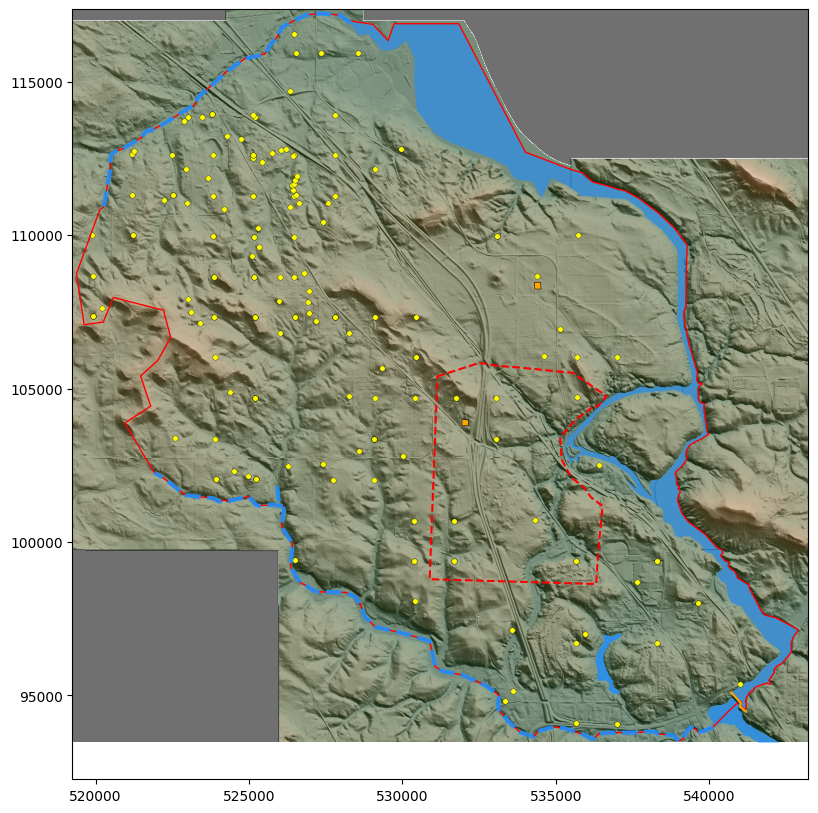

In [5]:
#visualize geospatial data
fig, ax = plt.subplots(figsize = (10,10), dpi=100)

# plot hillshade and use DEM to color
rioplot.show(hillshade_masked, transform=hillshade_dataset.transform, ax=ax, cmap = "Greys_r")
rioplot.show(dem_masked, transform=dem_dataset.transform, ax=ax, cmap = cm.fes, alpha=0.5, vmin=200, vmax=1400)

# model boundaries
farfield.boundary.plot(ax=ax,color='red', lw=1)
nearfield.boundary.plot(ax=ax, ls ='--', color='red')

# Add vector data to a plot using methods of the GeoDataFrame (Geopandas variable class)
no_river.plot(ax=ax,color='dodgerblue', alpha=0.6)
so_river.plot(ax=ax,color='dodgerblue', alpha=0.7)
lake.plot(ax=ax,color='dodgerblue', alpha=0.8)
streams.plot(ax=ax,color='dodgerblue', ls ='--', lw=3, alpha=0.9)
noflow.plot(ax=ax,color='orange')


# Well construction report data points
WCRs.plot(ax=ax, color = "yellow", edgecolor = 'k', markersize = 15, lw = 0.2)

# source zones
spills.plot(ax=ax, color = "orange", edgecolor = 'k', lw = 0.4)

# If you want to save this figure you could uncomment the following
# plt.savefig('model_input.png')
# if you want to zoom in on a subregion of your plot then use the follow to set different axis limits
# ax.set_xlim(526000, 540000)
# ax.set_ylim(95000, 115000)
plt.show()

## Create and visualize model grid

In [6]:
#create the model grid (+refined...)
delvp = [65, 210] # largely based off of ZE608 well construction report
print('pdepths will be: ', np.cumsum(delvp), ' ft')
cdepths = [14, 14, 14, 14, 14, 25, 25, 25, 25]
ncppl = [5, 4]
num_child_layers = int(np.sum(ncppl))
if num_child_layers == len(cdepths):
    print("all good")

    # pgrid, cgrid, lgr, ibound, topp, topc
    pgrid, cgrid, lgr, cbounds, topp, topc = GRIDbuilder(model_domain_shp = farfield,
                       idomain_shp = nearfield, 
                       cellsize = 150, #FEET but can be changed in length units of mfgwfdis package
                       nlay = 2, 
                       epsg = epsg, 
                       dem_file = dem_file, 
                       raster_interp_method = "nearest",
                       angle = 0,
                       ncpp = 10, 
                       ncppl = ncppl, 
                       build_child=True, import_tops = False)
else:
    print("child model depths must equal sum of ncppl!")

pdepths will be:  [ 65 275]  ft
all good
[519377.252188407, 93521.68865744778, 542889.0380286421, 117225.7659751]
resampling raster -- exporting to D:\Dropbox\Teaching\Contaminant hydro 629\Notebooks_unpublished\MF6\Upham_demo_data
Parent Model Grid created with resolution
 nlay: 2, nrow: 159, ncol: 157, delr: 150.0, delc: 150.0
parent grid creation in  3.371389865875244  sec

resampling raster -- exporting to D:\Dropbox\Teaching\Contaminant hydro 629\Notebooks_unpublished\MF6\Upham_demo_data
Child LGR Model Grid created with resolution
 nlay: 9, nrow: 490, ncol: 400, delr: 15.0, delc: 15.0
child grid creation in  3.5720369815826416  sec



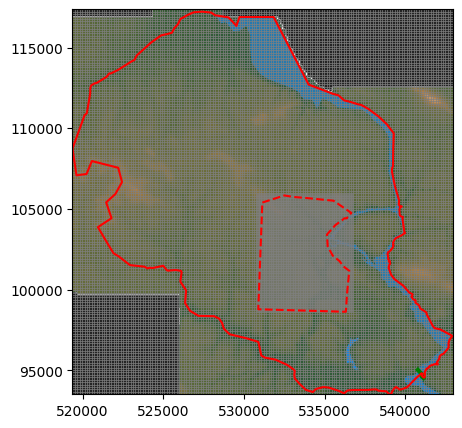

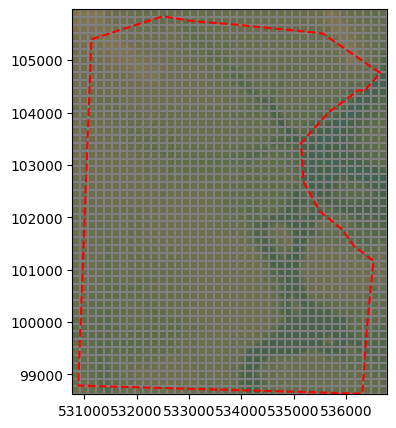

In [7]:
# mgrids is a tuple of the following: pgrid, cgrid, lgr, ibound, topp, topc
fig, ax = plt.subplots(figsize=(5, 5))
# plot interpolated DEM
plt.imshow(topp, extent=pgrid.extent, cmap = cm.fes, alpha=0.9, vmin=200, vmax=1400)
# plot child grid
cgrid.plot(ax=ax, lw=0.5, alpha=0.2)
# plot parent grid
pgrid.plot(ax=ax, lw=0.5)

noflow.plot(ax=ax, lw=3, color = "green")
no_river.plot(ax=ax,color='dodgerblue', alpha=0.6)
so_river.plot(ax=ax,color='dodgerblue', alpha=0.7)
lake.plot(ax=ax,color='dodgerblue', alpha=0.8)

# Plot boundaries
farfield.boundary.plot(ax=ax, color = "red")
nearfield.boundary.plot(ax=ax, ls='--', color='red')
plt.show()


## Plot child grid
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
# plot interpolated DEM
plt.imshow(topc, extent=cgrid.extent, cmap = cm.fes, alpha=0.9, vmin=200, vmax=1400)
# plot child grid
cgrid.plot(ax=ax, alpha=0.8, lw=0.1)
# plot parent grid
pgrid.plot(ax=ax)
no_river.plot(ax=ax,color='dodgerblue', alpha=0.1)

# Plot boundaries
farfield.boundary.plot(ax=ax, color = "red")
nearfield.boundary.plot(ax=ax, ls='--', color='red')

ax.set_xlim(cgrid.extent[0], cgrid.extent[1])
ax.set_ylim(cgrid.extent[2], cgrid.extent[3])

plt.show()

## Assign cells to different shape features, identify inactive cells and boundary conditions

In [8]:
#boundary intersections # mgrids is a tuple of the following: pgrid, cgrid, lgr, ibound, topp, topc
gx = GridIntersect(pgrid)

# regional model domain
idomain_intersect = gx.intersect(farfield.geometry[0], min_area_fraction=0.5, return_all_intersections=False)
mod_bound = list(idomain_intersect.cellids)

# find location of cells that fall within river polygon north of the Dells
no_river_intersect = gx.intersect(no_river.geometry[0], min_area_fraction=0.2, return_all_intersections=False)
# these numpy recarrays have dtypes of ('cellids', 'vertices', 'areas', 'ixshapes')
no_river_cells = list(no_river_intersect.cellids)
# find location of cells that fall within river polygon south of the Dells
so_river_intersect = gx.intersect(so_river.geometry[0], min_area_fraction=0.5, return_all_intersections=False)
so_river_cells = list(so_river_intersect.cellids)
river_datasets = [no_river_cells, so_river_cells]

# find location of cells that fall within the lake
lake_intersect = gx.intersect(lake.geometry[0], min_area_fraction=0.6, return_all_intersections=False)
lake_cells = list(lake_intersect.cellids)

# find cells with stream features
stream_cells = []
# loop through the stream features in the shape 
for cell_list in streams.geometry:
    stream_intersect = gx.intersect(cell_list, min_area_fraction=0.5, return_all_intersections=False)
    for cells in stream_intersect:
        stream_cells.append(cells.cellids)

#noflow cells
noflow_bd = []
for iloc, row in noflow.iterrows():
    results = gx.intersect(row.geometry, min_area_fraction=None, return_all_intersections=True)
    # get cellids of no flow cells
    noflow_bd += list(results.cellids)

# Extract Cell IDs of WCRs
obs_cells = np.zeros((len(WCRs), 2), dtype=int)
for i, (iloc, row) in enumerate(WCRs.iterrows()):
    # parent mesh 
    results = gx.intersect(row.geometry, contains_centroid=True)
    # as np array
    obs_cells[i, :] = np.array(results.cellids[0], dtype=int)

In [9]:
# Now get location of spill site locations. Note that spill 0 is outside the child model boundarys
print(spills)

   id                                           geometry
0   1  POLYGON ((534303.045 108464.712, 534507.648 10...
1   2  POLYGON ((531942.040 103990.378, 532152.027 10...


In [10]:
# Now child mesh gridintersect
cx = GridIntersect(cgrid)
## also intersecting features of the local/child grid
spill_intersect = cx.intersect(spills.geometry[1], min_area_fraction=0.1, return_all_intersections=False)
source_cells = list(spill_intersect.cellids)

print(source_cells)

[(132, 77), (132, 78), (132, 79), (132, 80), (132, 81), (132, 82), (132, 83), (132, 84), (132, 85), (132, 86), (132, 87), (132, 88), (132, 89), (133, 77), (133, 78), (133, 79), (133, 80), (133, 81), (133, 82), (133, 83), (133, 84), (133, 85), (133, 86), (133, 87), (133, 88), (133, 89), (133, 90), (133, 91), (134, 77), (134, 78), (134, 79), (134, 80), (134, 81), (134, 82), (134, 83), (134, 84), (134, 85), (134, 86), (134, 87), (134, 88), (134, 89), (134, 90), (134, 91), (135, 77), (135, 78), (135, 79), (135, 80), (135, 81), (135, 82), (135, 83), (135, 84), (135, 85), (135, 86), (135, 87), (135, 88), (135, 89), (135, 90), (135, 91), (136, 77), (136, 78), (136, 79), (136, 80), (136, 81), (136, 82), (136, 83), (136, 84), (136, 85), (136, 86), (136, 87), (136, 88), (136, 89), (136, 90), (136, 91), (137, 77), (137, 78), (137, 79), (137, 80), (137, 81), (137, 82), (137, 83), (137, 84), (137, 85), (137, 86), (137, 87), (137, 88), (137, 89), (137, 90), (137, 91), (138, 77), (138, 78), (138, 79)

In [11]:
#Boundary Condition Assignment
bounds = np.zeros(topp.shape)

# create tuples of rec arrays
j_bd, i_bd = zip(*mod_bound)
j_nf, i_nf = zip(*noflow_bd)
j_no, i_no = zip(*no_river_cells)
j_so, i_so = zip(*so_river_cells)
j_st, i_st = zip(*stream_cells)
j_la, i_la = zip(*lake_cells)

# no flow
bounds[j_nf, i_nf] = 1
# main domain
bounds[j_bd, i_bd] = 2
# stream cells
bounds[j_st, i_st] = 3
# Constant head cells
# river cells
bounds[j_no, i_no] = 10
bounds[j_so, i_so] = 11
# lake cells
bounds[j_la, i_la] = 12

#return the mean river stage in north_river and south river
mean_stg_no = np.nanmean(np.where(bounds == 10, topp, np.nan))
# mean_stg_no = np.nanmean(np.where(bounds ==mean_stg_no, topp, np.nan))
print("mean river stage in north of Kilbourn Dam: ", mean_stg_no)
mean_stg_so = np.nanmean(np.where(bounds == 11, topp, np.nan))
print("mean river statge south of Kilbourn Dam: ", mean_stg_so)
# # identify lake level from DEM
mean_lake = np.nanmean(np.where(bounds == 12, topp, np.nan))
print("mean lake level: ", mean_lake)
# mask the features for plotting model bounds
bounds_mask = np.ma.masked_values(bounds, 2)

# river cells
bounds[j_no, i_no] = mean_stg_no
bounds[j_so, i_so] = mean_stg_so
# lake cells
bounds[j_la, i_la] = mean_lake
# print(bounds[:,60])

mean river stage in north of Kilbourn Dam:  836.873959608481
mean river statge south of Kilbourn Dam:  807.8719618055555
mean lake level:  835.6400146484375


Note that this is a bit of an oversimplification of the head of the river upstream of the dam because we are assuming the head is constant. Because the river is impounded, it is pretty lake-like in this case. If you really want to get fancy you could try to assume some constant head drop in the river using the DEM data (with some data cleaning) as illustrated in the commented cell below.

In [12]:
# For the river north of Kilbourn dam we want to account for the change in river stage along the length of the model.
# To do this, let's fit a surface to all of the river data points in order to smooth out some of the jumps in the 
# stiched DEM
# let's choose only cells that are entirely within the river polygon
no_river_intersect_slim = gx.intersect(no_river.geometry[0], min_area_fraction=0.99, return_all_intersections=False)
# these numpy recarrays have dtypes of ('cellids', 'vertices', 'areas', 'ixshapes')
no_river_cells_slim = list(no_river_intersect_slim.cellids)
j_nos, i_nos = zip(*no_river_cells_slim)

# now crop the cells in the lower tiles, there is a pretty significant offset in DEM that is causing issues
crop_cells = 500
# cropped cell indices
j_nosc = j_nos[:crop_cells]
i_nosc = i_nos[:crop_cells]
# # also crop cells greater than 836 ft as there looks to be another offset in the DEM around that threshold
crop_ind = np.squeeze(np.argwhere(topp[j_nosc, i_nosc] < 836))
j_nosc= [j_nosc[i] for i in crop_ind]
i_nosc = [i_nosc[i] for i in crop_ind]

# Define x, y, and z coordinates
xs = np.array(j_nosc)
ys = np.array(i_nosc)
# extract z from DEM
zs = topp[j_nosc, i_nosc]

# Build A matrix for some linear algebra
tmp_A=[]
for i in range(len(xs)):
    tmp_A.append([xs[i], ys[i], 1])
    # tmp_b.append(zs[i])
b = np.matrix(zs).T
A = np.matrix(tmp_A)

# Manual solution
fit = (A.T * A).I * A.T * b
print('coefficients of plane (a,b,c): ', fit.T) # a, b, c coefficients of equation  ax+by+c=z


# fit data
river_interp = np.empty(topp.shape)
river_interp[:]= np.NaN
# calculate river cells from fit surface
xi = np.array(j_no)
yi = np.array(i_no)
# Build A matrix for some linear algebra
tmp_Ai=[]
for i in range(len(xi)):
    tmp_Ai.append([xi[i], yi[i], 1])

# now apply river interpolation to all river cells
river_interp[j_no, i_no] = np.squeeze(tmp_Ai*fit)

coefficients of plane (a,b,c):  [[-1.65631128e-03 -1.33761243e-03  8.34143060e+02]]


## Visualize cell assignments and boundary conditions

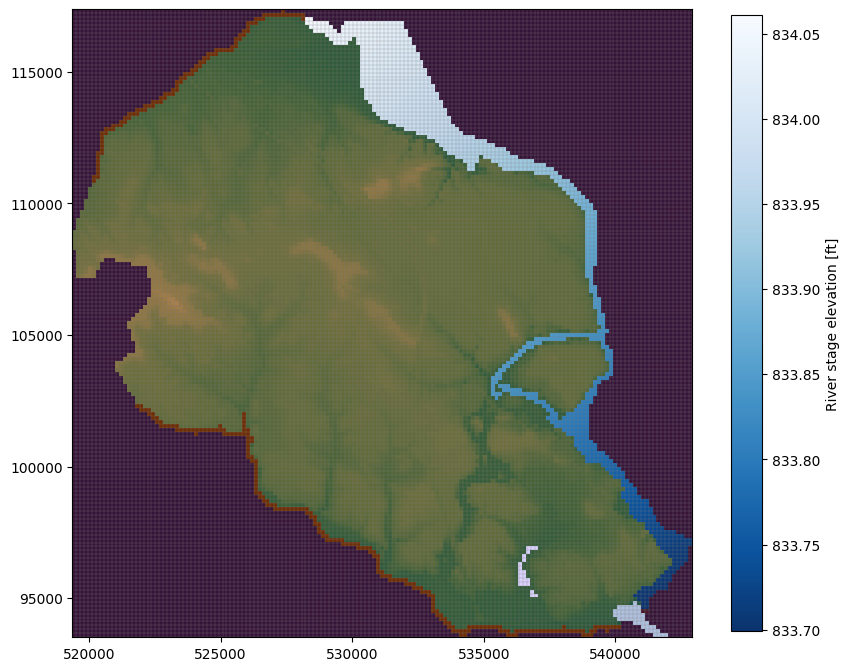

In [13]:
# Visualize boundary conditions
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
# plot interpolated DEM
plt.imshow(topp, extent=pgrid.extent, cmap = cm.fes, alpha=0.9, vmin=200, vmax=1400)
# plot cell bounds
plt.imshow(bounds_mask, extent=pgrid.extent, cmap=cm.glasgow, alpha=0.99)
plt.imshow(river_interp, extent=pgrid.extent, cmap = 'Blues_r', alpha=0.99)
# plt.imshow(river_flat, extent=pgrid.extent, cmap = 'Blues_r', alpha=0.99)
plt.colorbar(label = 'River stage elevation [ft]', shrink = 0.8)
# plot parent grid
pgrid.plot(ax=ax, lw=0.2)
# plt.savefig('model_BC_corrected_to_levelogger.png')

plt.show()

## Build the MODFLOW model

In [14]:
#NWT simplified model.
#https://modflow6-examples.readthedocs.io/en/master/_examples/ex-gwf-nwt-p03.html
def Upham_Mf6(sim_name, exe_loc, outdir, pgrid, delvp, bounds, no_river_cells, so_river_cells, lake_cells, stream_cells,
            strt_head, river_interp, topp, recharge, hk,      #general steady-state model inputs
            perlen, # days, this the length of the simulation if steady=True, if steady =False then this is the stress period length
            child_model = False, cgrid=[], cdepths=[], topc=[], lgr=[], # child model inputs (optional)
            ): 
    """
    Arguments:
    no_river_cells: These cells describe river constant head boundaries north of Kilbourn Dam. The
    head values may vary and should be provided in the 'river_interp' input.

    perlen (int): Number of days of entire simulation if steady=True, if steady =False then this 
    is the stress period length. Note that this is also the time interval that the river stage series
    data is averaged and resampled from.
    
    time series data should be a pandas dataseries indexed by datetime. The stage should be in feet 
    above sea level ["stage"]. This can be done with the following code:
    # Convert 'datetime' column to datetime type 
    D2['datetime'] = pd.to_datetime(D2['datetime'])
    # Set 'datetime' as the index for both DataFrames
    D2.set_index('datetime', inplace=True)

    sy = Specific yield is defined as the volume of water released from storage by an unconfined aquifer 
    per unit surface area of aquifer per unit decline of the water table. Bear (1979) relates specific yield to total porosity as follows:
    n=Sy+Sr
    where n is total porosity [dimensionless], Sy is specific yield [dimensionless] and Sr is specific retention [dimensionless], the amount 
    of water retained by capillary forces during gravity drainage of an unconfined aquifer. 
    Thus, specific yield, which is sometimes called effective porosity, is less than the total porosity of an unconfined aquifer.
    """

    # Set up path to model output folder
    if not os.path.exists(os.path.join(outdir, sim_name)):
        os.mkdir(os.path.join(outdir, sim_name))
    model_dir = os.path.join(outdir, sim_name)
    print("building groundwater simulation--output location: {}".format(model_dir))
    
    # create the MF6 simulation
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, exe_name=os.path.join(exe_loc, 'mf6.exe'), sim_ws=model_dir)

    # create tdis package #units will be in feet and days
    D_stage = [0]
    nstp = [1] # is the number of time steps in a stress period.
    tsmult = [1.0] # the multiplier for the length of successive time steps. The length of a time step is calculated by multiplying the length of the previous time step by TSMULT. 
    tdis_rc = list(zip(perlen, nstp, tsmult))
    nper = len(perlen)

    # ModflowTdis defines a tdis package.
    tdis = flopy.mf6.ModflowTdis(sim, pname='tdis', time_units='DAYS', nper = nper, perioddata=tdis_rc)
    
    # PARENT MODEL============================================================================================================================
    # initialize the parent gwf model
    model_name = 'parent'
    # Modflowgwf defines a gwf model
    gwf = flopy.mf6.ModflowGwf(sim, modelname=model_name, model_nam_file='{}.nam'.format(model_name), 
                               save_flows=True)#, newtonoptions = "newton under_relaxation")
    
    # ModflowIms defines the ims package
    ims = flopy.mf6.ModflowIms(sim, complexity = "MODERATE")
    # ims = flopy.mf6.ModflowIms(sim, complexity = "MODERATE", linear_accelerator = "BICGSTAB", inner_dvclose = 0.1)
    
    # dis Package    =========================================================================================================================    
    nlay, nrow, ncol, delr, delc = pgrid.nlay, pgrid.nrow, pgrid.ncol, pgrid.delr, pgrid.delc
    
    botmp = []
    pdepths = np.cumsum(delvp)
    for lay in range(nlay):
        layer = topp - pdepths[lay]
        botmp.append(layer)
    botmp = np.asarray(botmp)
    # botmp[-1] = 500 #set all depths in the last layer to 500 ft -- corresponding to the mt simon

    # set all cells in model within domain to active cells (except no flow cells)
    # If the IDOMAIN value for a cell is 1 or greater, the cell exists in the simulation. If the IDOMAIN value for a cell is -1 or 0, the cell does not exist in the simulation.
    idomain = np.zeros([nlay, nrow, ncol])
    idomain[:, bounds > 1] = 1
    
    dis = flopy.mf6.ModflowGwfdis(gwf, length_units='FEET', nlay=nlay, nrow=nrow, ncol=ncol,
        delr=delr, delc=delc, top=topp, botm=botmp, idomain=idomain, 
        xorigin = pgrid.extent[0], yorigin = pgrid.extent[2])
    
    # IC package
    # strt (double) is the initial (starting) head—that is, head at the beginning of the GWF Model simulation.
    strt = np.ones([nlay, nrow, ncol])*strt_head
    ic = flopy.mf6.ModflowGwfic(gwf, pname='ic', strt=strt)
    
    # Constant head (CHD) Package  ========================================================================================================== 
    # Set conditions that will be constant all of the time
    cspd_constant = [] #rec arrays
    for (i, j) in lake_cells: 
            # cellid ,   Head 
            cspd_constant.append(((0, i, j), bounds[i,j]))
    for (i, j) in so_river_cells: # south of kilburn dam
            # cellid ,   Head 
            cspd_constant.append(((0, i, j), bounds[i,j]))

    # Now edit river cells 
    cspd_perdata = {}
    cspd = []
    # Loop through north river cells
    for (i, j) in no_river_cells: # north river
        # if interpolating along river surface
        if river_interp.size>1:
            # cellid ,   Head 
            cspd.append(((0, i, j), river_interp[i,j]))
        else: # or if applying constant river head
            cspd.append(((0, i, j), river_interp))
    
    cspd_uniques = set(cspd_constant + cspd) #find and remove and duplicate geometry      
    cspd_perdata = {0: list(cspd_uniques)}#, 1: list(cspd_uniques)}
        
    
    chd = flopy.mf6.ModflowGwfchd(gwf, save_flows=True, maxbound=len(cspd_uniques), stress_period_data = cspd_perdata, pname = '.chd')

    # NPF package ========================================================================================================================   
    # icelltype (integer) flag for each cell that specifies how saturated thickness is treated. 0 means saturated thickness is held constant; >0 means saturated thickness varies with computed head when head is below the cell top; 
    icelltypec = np.zeros((nlay))
    icelltypec[0] = 1
    # K33 is a ratio of K33 divided by K. If k33overk=True, then the K33 array entered in the NPF Package will be multiplied by K after being read.
    npf = flopy.mf6.ModflowGwfnpf(gwf, k33overk=True, icelltype=icelltypec, k=hk, k33=0.1)

    # Recharge RCHA package ============================================================================================================== 
    # recharge could be estimated with https://www.usgs.gov/centers/upper-midwest-water-science-center/science/soil-water-balance-swb-a-modified-thornthwaite
    # Recharge (double) is the recharge flux rate L/T
    # if readasarrays=True then define
    crcha = np.ones((nrow, ncol))*recharge
    rcha = flopy.mf6.ModflowGwfrcha(gwf, readasarrays=True, recharge=crcha) 

    # drains (drn) Package =============================================================================================================
    drnspd = []
    # hydraulic conductance of the interface between the aquifer and the drain
    # conductance is the horizontal area of flow (portion of cell with a stream) A * hK/b where b is the thickness of the sediments
    b = 2 # feet
    stream_hk = hk[0]/10
    cond = stream_hk*(delc[0])*(delr[0]*0.1)/b
    for (i, j) in stream_cells:        
        drnspd.append(((0, i, j), topp[i,j], cond))

    # river_cond = stream_hk*(delc[0])*(delr[0])/b
    # for (i, j) in no_river_cells: # north river
    #     drnspd.append(((0, i, j), topp[i,j], river_cond))

    # format drain information into a dictionary
    drnspd_perdata = {0: drnspd}

    # drains package (check out Will's Rhinelander model for observations integration)
    drn = flopy.mf6.ModflowGwfdrn(gwf,save_flows=True, maxbound=len(drnspd_perdata[0]), 
                                  stress_period_data=drnspd_perdata)
    
    #Output control for the parent model ===============================================================================================
    oc = flopy.mf6.ModflowGwfoc(gwf, pname='oc', budget_filerecord='parent.cbc', budgetcsv_filerecord = 'parent_budget.csv',
                                head_filerecord='parent.hds',
                                headprintrecord=[('COLUMNS', 10, 'WIDTH', 15, 'DIGITS', 4, 'GENERAL')],
                                saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')], #ALL
                                printrecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])
    
    sim.register_ims_package(ims, gwf.name)
    
    
    if child_model == True:
        # Name new model added to simulation
        model_namec = "child"
        cgwf = flopy.mf6.ModflowGwf(sim, modelname=model_namec, model_nam_file='child.nam', save_flows=True)
    
        #register the model with the solver
        sim.register_ims_package(ims, [gwf.name, cgwf.name])

        #lgr information
        cnlay, cnrow, cncol = lgr.get_shape()
        cdelr, cdelc = lgr.get_delr_delc()
        cibound = lgr.get_idomain()
        xorigin, yorigin = lgr.get_lower_left()
    
        botmc = []
        ccumdepths = np.cumsum(cdepths)
        for lay in range(cnlay):
            layer = topc - ccumdepths[lay]
            botmc.append(layer)
        botmc = np.asarray(botmc)  
    
        cgwf.modelgrid.set_coord_info(xoff=xorigin, yoff=yorigin) #originally this is xorigin and y origin
                
        cdis = flopy.mf6.ModflowGwfdis(cgwf, nlay=cnlay, nrow=cnrow, ncol=cncol, delr=cdelr, 
                                   delc=cdelc, top=topc, botm=botmc, idomain=cibound,
                                   xorigin=xorigin, yorigin=yorigin)
    
        #double account that lgr model tops and bottoms are the same as the cdis
        lgr.top = cgwf.dis.top.array
        lgr.botm = cgwf.dis.botm.array
        
        # Define initial head conditions to be same in child model as parent model
        strtc = np.ones([cgrid.nlay, cgrid.nrow, cgrid.ncol])*strt_head
        cic = flopy.mf6.ModflowGwfic(cgwf, pname='ic', strt=strtc)
        
        #node property flow
        # icelltype (integer) flag for each cell that specifies how saturated thickness is treated. 
        # 0 means saturated thickness is held constant; 
        # >0 means saturated thickness varies with computed head when head is below the cell top; 
        icelltypec = np.ones((cnlay))
        icelltypec[-2:] = 0
        # set hydraulic conductivity
        hk_c = np.repeat(hk[0], cnlay)
        
        cnpf = flopy.mf6.ModflowGwfnpf(cgwf,  save_flows = True, k33overk=True, 
                                   icelltype=icelltypec, k=hk_c, 
                                   k33 = 0.1, save_specific_discharge=True, save_saturation=True)
        
        # RECHARGE ==================================================================================================================================    
        crcha = np.ones((cnrow, cncol))*recharge
        crch = flopy.mf6.ModflowGwfrcha(cgwf, readasarrays=True, recharge=crcha) #ft/day
    
        #==================================================================================================================================    
        coc = flopy.mf6.ModflowGwfoc(cgwf, pname='oc', budget_filerecord='child.cbc', budgetcsv_filerecord = 'child_budget.csv',
                            head_filerecord='child.hds', 
                            headprintrecord=[('COLUMNS', 10, 'WIDTH', 15, 'DIGITS', 4, 'GENERAL')],
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                            printrecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])
    
        #most important -- set up the groundwater flow exchange=============================================================
        exchangedata = lgr.get_exchange_data(angldegx=True, cdist=True)
        nexg = len(exchangedata)
        
        gwfe = flopy.mf6.ModflowGwfgwf(sim, 
                            exgtype='gwf6-gwf6', 
                            exgmnamea='parent', 
                            exgmnameb='child', 
                            nexg=nexg, 
                            auxiliary=[('angldegx', 'cdist')], 
                            exchangedata=exchangedata)
        print("Child Model now included")
        
    #would be cool to print a little model summary...
    print("Done!")
    return sim

## Run Simulation

In [72]:
# name of model
sim_name = 'ss_flow8'
# set initial head to the mean river stage north of the dam
strt_head = mean_stg_no
perlen = [365.0] # if steady = True (default) then this is the simulation length, if not steady state then this is the increment of discretization (perlen)
recharge = 12/12/365  # (Ft/Day) 12 inches per year based on Columbia county survey map https://wgnhs.wisc.edu/pubshare/WOFR2012-02.pdf
# In the future it might be nice to incorporate SWB model of recharge https://www.usgs.gov/centers/upper-midwest-water-science-center/science/soil-water-balance-swb-a-modified-thornthwaite
# set hk in each layer of parent model, currently all child layers take top parent model hk
hk = [50, 7.5] # ft/day

# Call model function
sim_ss = Upham_Mf6(sim_name, exe_loc, outdir, pgrid, delvp, bounds, no_river_cells, so_river_cells, lake_cells, stream_cells,
            strt_head, river_interp, topp, recharge, hk, perlen,
                  child_model = True, cgrid=cgrid, cdepths=cdepths, topc=topc, lgr=lgr)      #general steady-state model inputs

# Write and run model
sim_ss.write_simulation(silent=True)
sim_ss.run_simulation(silent=False)
# print(D_stage)

building groundwater simulation--output location: D:\Dropbox\Teaching\Contaminant hydro 629\Contaminant-Hydrogeology-Activities\MF6_field_scale_model_examples\ss_flow8
Child Model now included
Done!
FloPy is using the following executable to run the model: C:\Hydro\mf6.4.2\mf6.4.2_win64\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.2 06/28/2023

   MODFLOW 6 compiled Jun 28 2023 18:41:13 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as 

(True, [])

## Analyze Model Output
Start by extracting the static water levels from the WCR GIS data and calculate the mismatch betwen the model and these observations (termed 'residuals').

In [16]:
model_names = list(sim_ss.model_names)

#get the models as outputs
# regional/parent flow model
gwf_ss = sim_ss.get_model(model_names[0]) #groundwater flow model
# Extract heads
head = gwf_ss.output.head().get_alldata()
heads = np.ma.masked_where(head < 1e29, head)

# get the water table
wtr_tbl = get_water_table(head)
# wtr_tblc = get_water_table(headc)

model_obs = wtr_tbl[obs_cells[:,0], obs_cells[:,1]]
residuals = model_obs - WCRs['WaterEleva'].to_numpy() 
WCRs['residuals'] = residuals

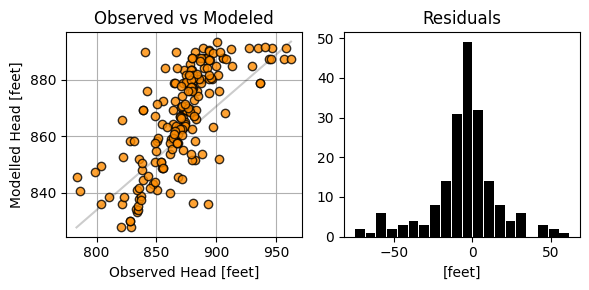

In [17]:
# plot comparison of heads vs WCRs
fig, ax = plt.subplots(1, 2, figsize = (6,3), dpi = 100)

ax[0].plot([WCRs['WaterEleva'].min(), WCRs['WaterEleva'].max()], [model_obs.min(), model_obs.max()], 'k', alpha = 0.2)
ax[0].scatter(WCRs['WaterEleva'], model_obs, color = "darkorange", edgecolor = "k", alpha = 0.8, zorder = 10)
# ax[0].plot( [min_val, max_val], [min_val, max_val], ls = "--", c = "k")
ax[0].set_title("Observed vs Modeled")
ax[0].set_xlabel("Observed Head [feet]")
ax[0].set_ylabel("Modelled Head [feet]")
ax[0].grid()

#residuals plot
ax[1].hist(residuals, bins = 20, color='k', rwidth=0.91)
ax[1].set_title("Residuals")
ax[1].set_xlabel("[feet]")
plt.tight_layout()
# plt.savefig('residuals_hk14_recharge12.png')
plt.show()

# Example model plots
The first plot illustrates how to plot the WCR residuals relative to the model output. The second plot is a cross section of the model at the location denoted by the red dashed line in the first plot. The second plot is just a prettier version of the field scale flow model with no well construction data plotted.

Note that you can easily save these plots to your directly by uncommenting the command `plt.savefig('savefilename')`.

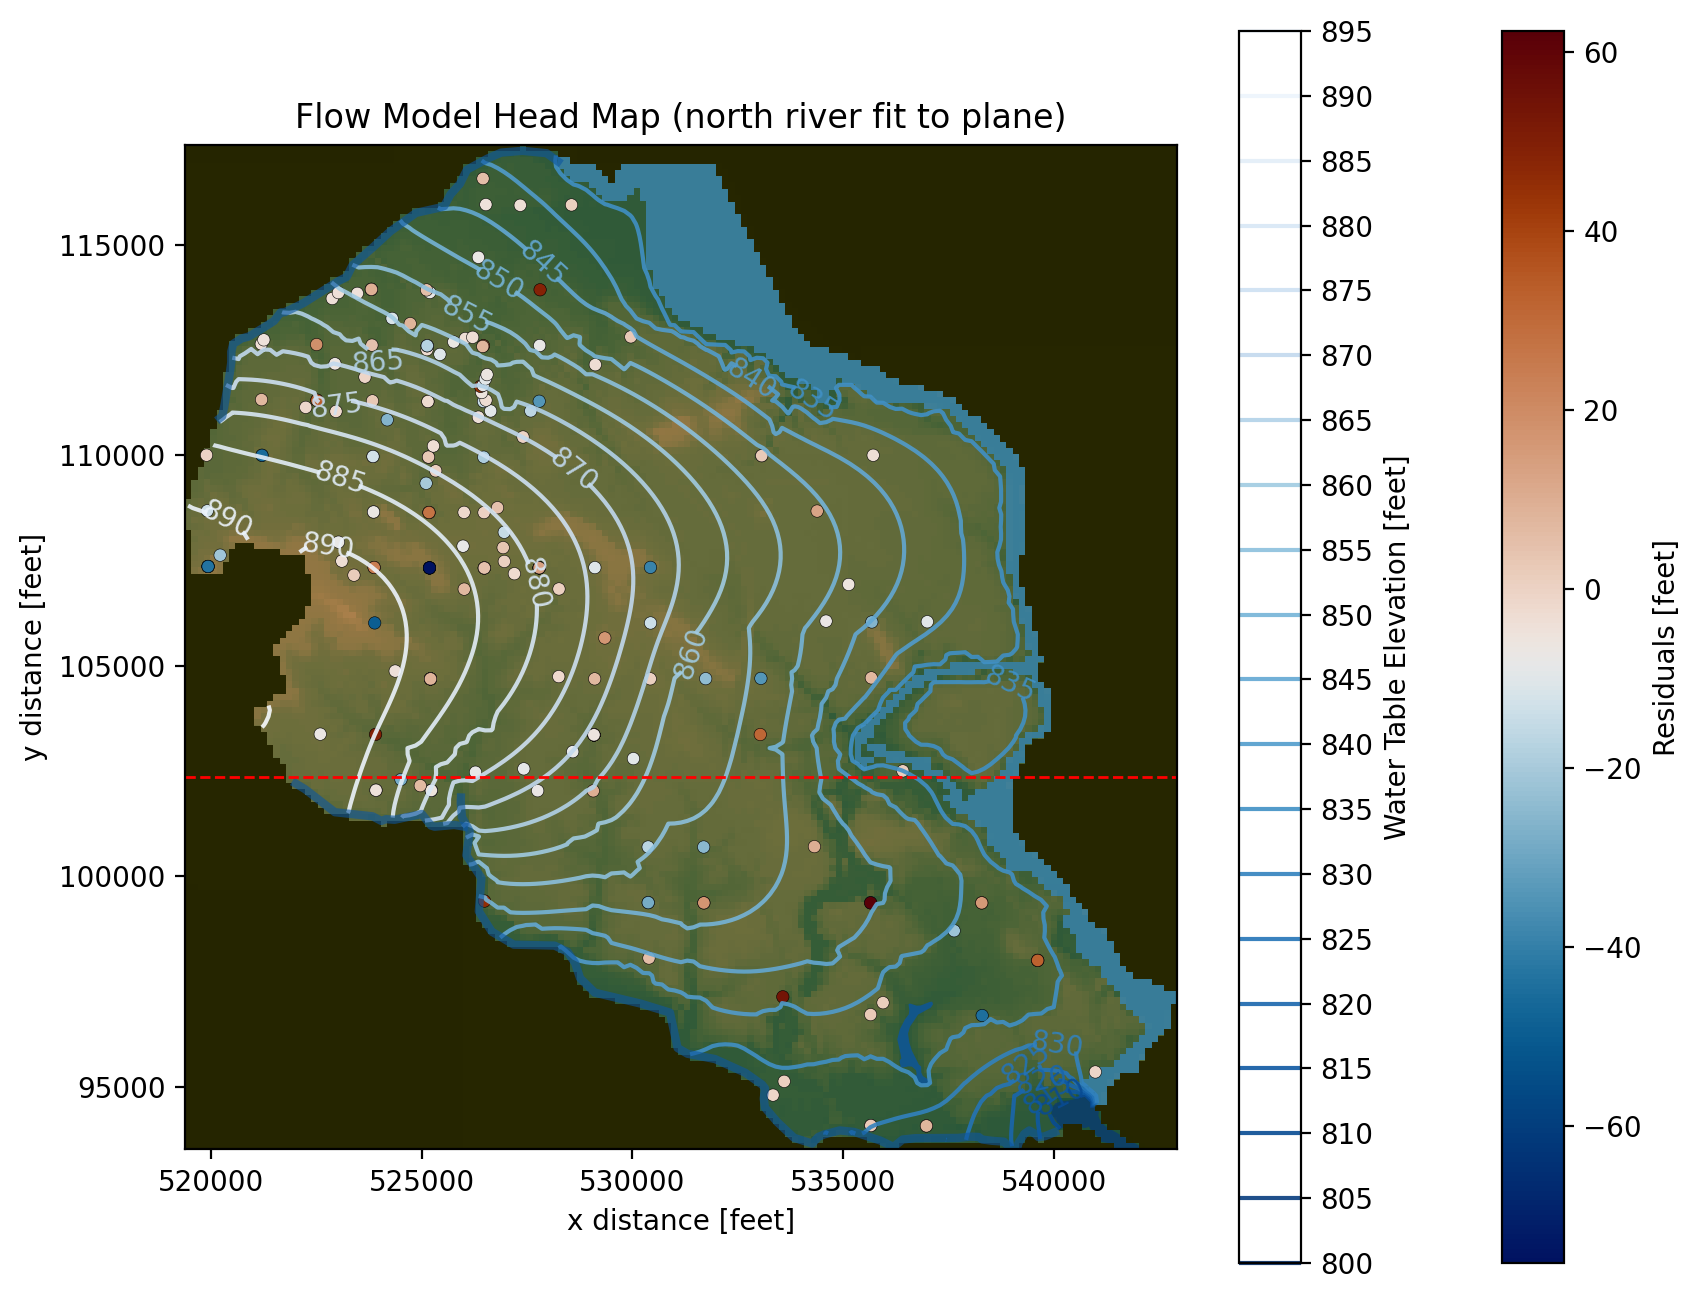

In [18]:
# water table plot
time_stp = 1
fig, ax = plt.subplots(1,1, figsize = (10, 10), dpi=200)
xmin, xmax, ymin, ymax = gwf_ss.modelgrid.extent

pmv = flopy.plot.PlotMapView(model=gwf_ss, ax = ax, layer = 0)

# Plot water table contours
levels = np.arange(800, 900, 5)
pmv_ts = pmv.contour_array(wtr_tbl, cmap = 'Blues_r', levels=levels, alpha = 0.9)
ax.clabel(pmv_ts, inline=True, fontsize=10)
# Plot water table as a map
# pmv_ts = pmv.plot_array(wtr_tbl, cmap = 'Blues_r', alpha = 0.9)

# plot interpolated DEM
plt.imshow(topp, extent=pgrid.extent, cmap = cm.fes, alpha=0.9, vmin=200, vmax=1400)
# Plot north river interpolation
plt.imshow(river_interp, extent=pgrid.extent, cmap = 'Blues_r', alpha=0.70, vmin=levels.min(), vmax=levels.max())

# plot other constant head boundaries (on same colorscale)
bluecolors = plt.cm.Blues_r(np.arange(0, levels.max() - levels.min() ,1))
so_river.plot(ax=ax, color=bluecolors[round(mean_stg_so)-800], alpha=0.7)
lake.plot(ax=ax, color=bluecolors[round(mean_lake)-800], alpha=0.8)

# plot drains
streams.plot(ax=ax, color=bluecolors[round(mean_stg_no)-800], lw=3, alpha=0.6)

# Show model outline
pmv.plot_array(gwf_ss.dis.idomain.array[0], masked_values=[1], cmap=cm.broc_r, alpha=0.99)

# Plot cross section location
line_loc = 100
# north-south line
# plt.axvline(xmin+(line_loc*gwf_ss.dis.delc[0]), c = 'red', ls = "--")
# east west line
plt.axhline(ymax-(line_loc*gwf_ss.dis.delr[0]), c = 'red', lw=1, ls = "--")

# Plot WCR residuals
wcr_plot = WCRs.plot(ax=ax, column='residuals', cmap = cm.vik, edgecolor = 'k', markersize = 20, lw = 0.2)
# add colorbar
norm = mcolors.Normalize(vmin=residuals.min(), vmax=residuals.max())
sm = plt.cm.ScalarMappable(cmap=cm.vik, norm=norm)
plt.colorbar(sm, ax=ax, label = "Residuals [feet]", shrink = 0.8)

plt.colorbar(pmv_ts, label = "Water Table Elevation [feet]", ticks=levels, shrink = 0.8)

ax.set_title("Flow Model Head Map (north river fit to plane)")
ax.set_xlabel("x distance [feet]")
ax.set_ylabel("y distance [feet]")

# to save as pdf
# plt.savefig('Model_plot_1.pdf')
# to save as png
# plt.savefig('Model_plot_1.png')
plt.show()


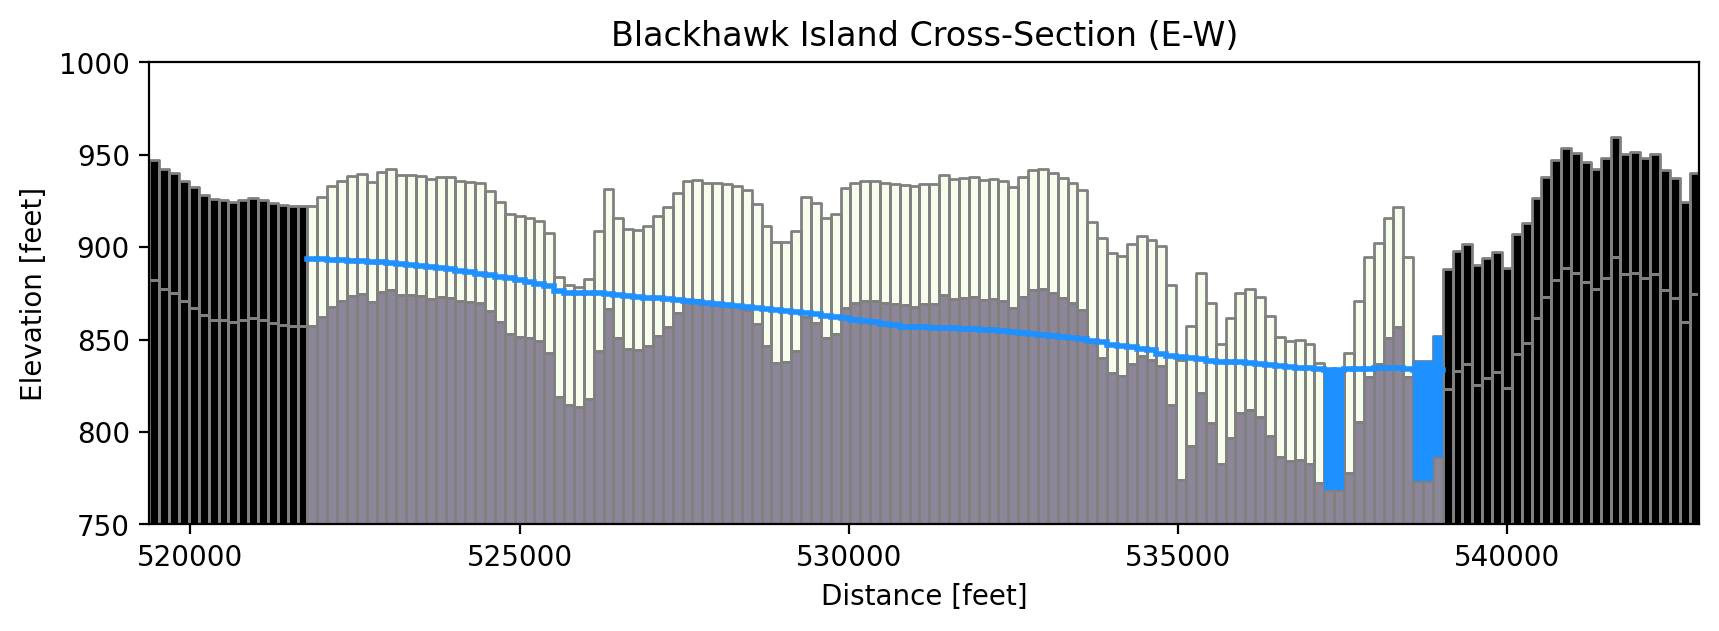

In [19]:
#cross section n-s
fig, ax = plt.subplots(1,1, figsize = (10, 3), dpi=200)

pxs = flopy.plot.PlotCrossSection(model=gwf_ss, ax = ax, line = {"row": line_loc}, geographic_coords=True)
# plot cell elevations
pxs.plot_array(gwf_ss.npf.k.array, alpha = 0.5, cmap=cm.tokyo)
pxs.plot_inactive(ibound=gwf_ss.dis.idomain.array, color_noflow='black')

# plot grid
xg = pxs.plot_grid(lw=1)

# plot rivers in blue
pxs.plot_bc("CHD", color = "dodgerblue")

cb = pxs.plot_surface(wtr_tbl, lw = 2, color = "dodgerblue")

ax.set_ylim(750, 1000)
ax.set_title("Blackhawk Island Cross-Section (E-W)")
ax.set_xlabel("Distance [feet]")
ax.set_ylabel("Elevation [feet]")
# plt.savefig('Upham_cross_section.png')
plt.show()

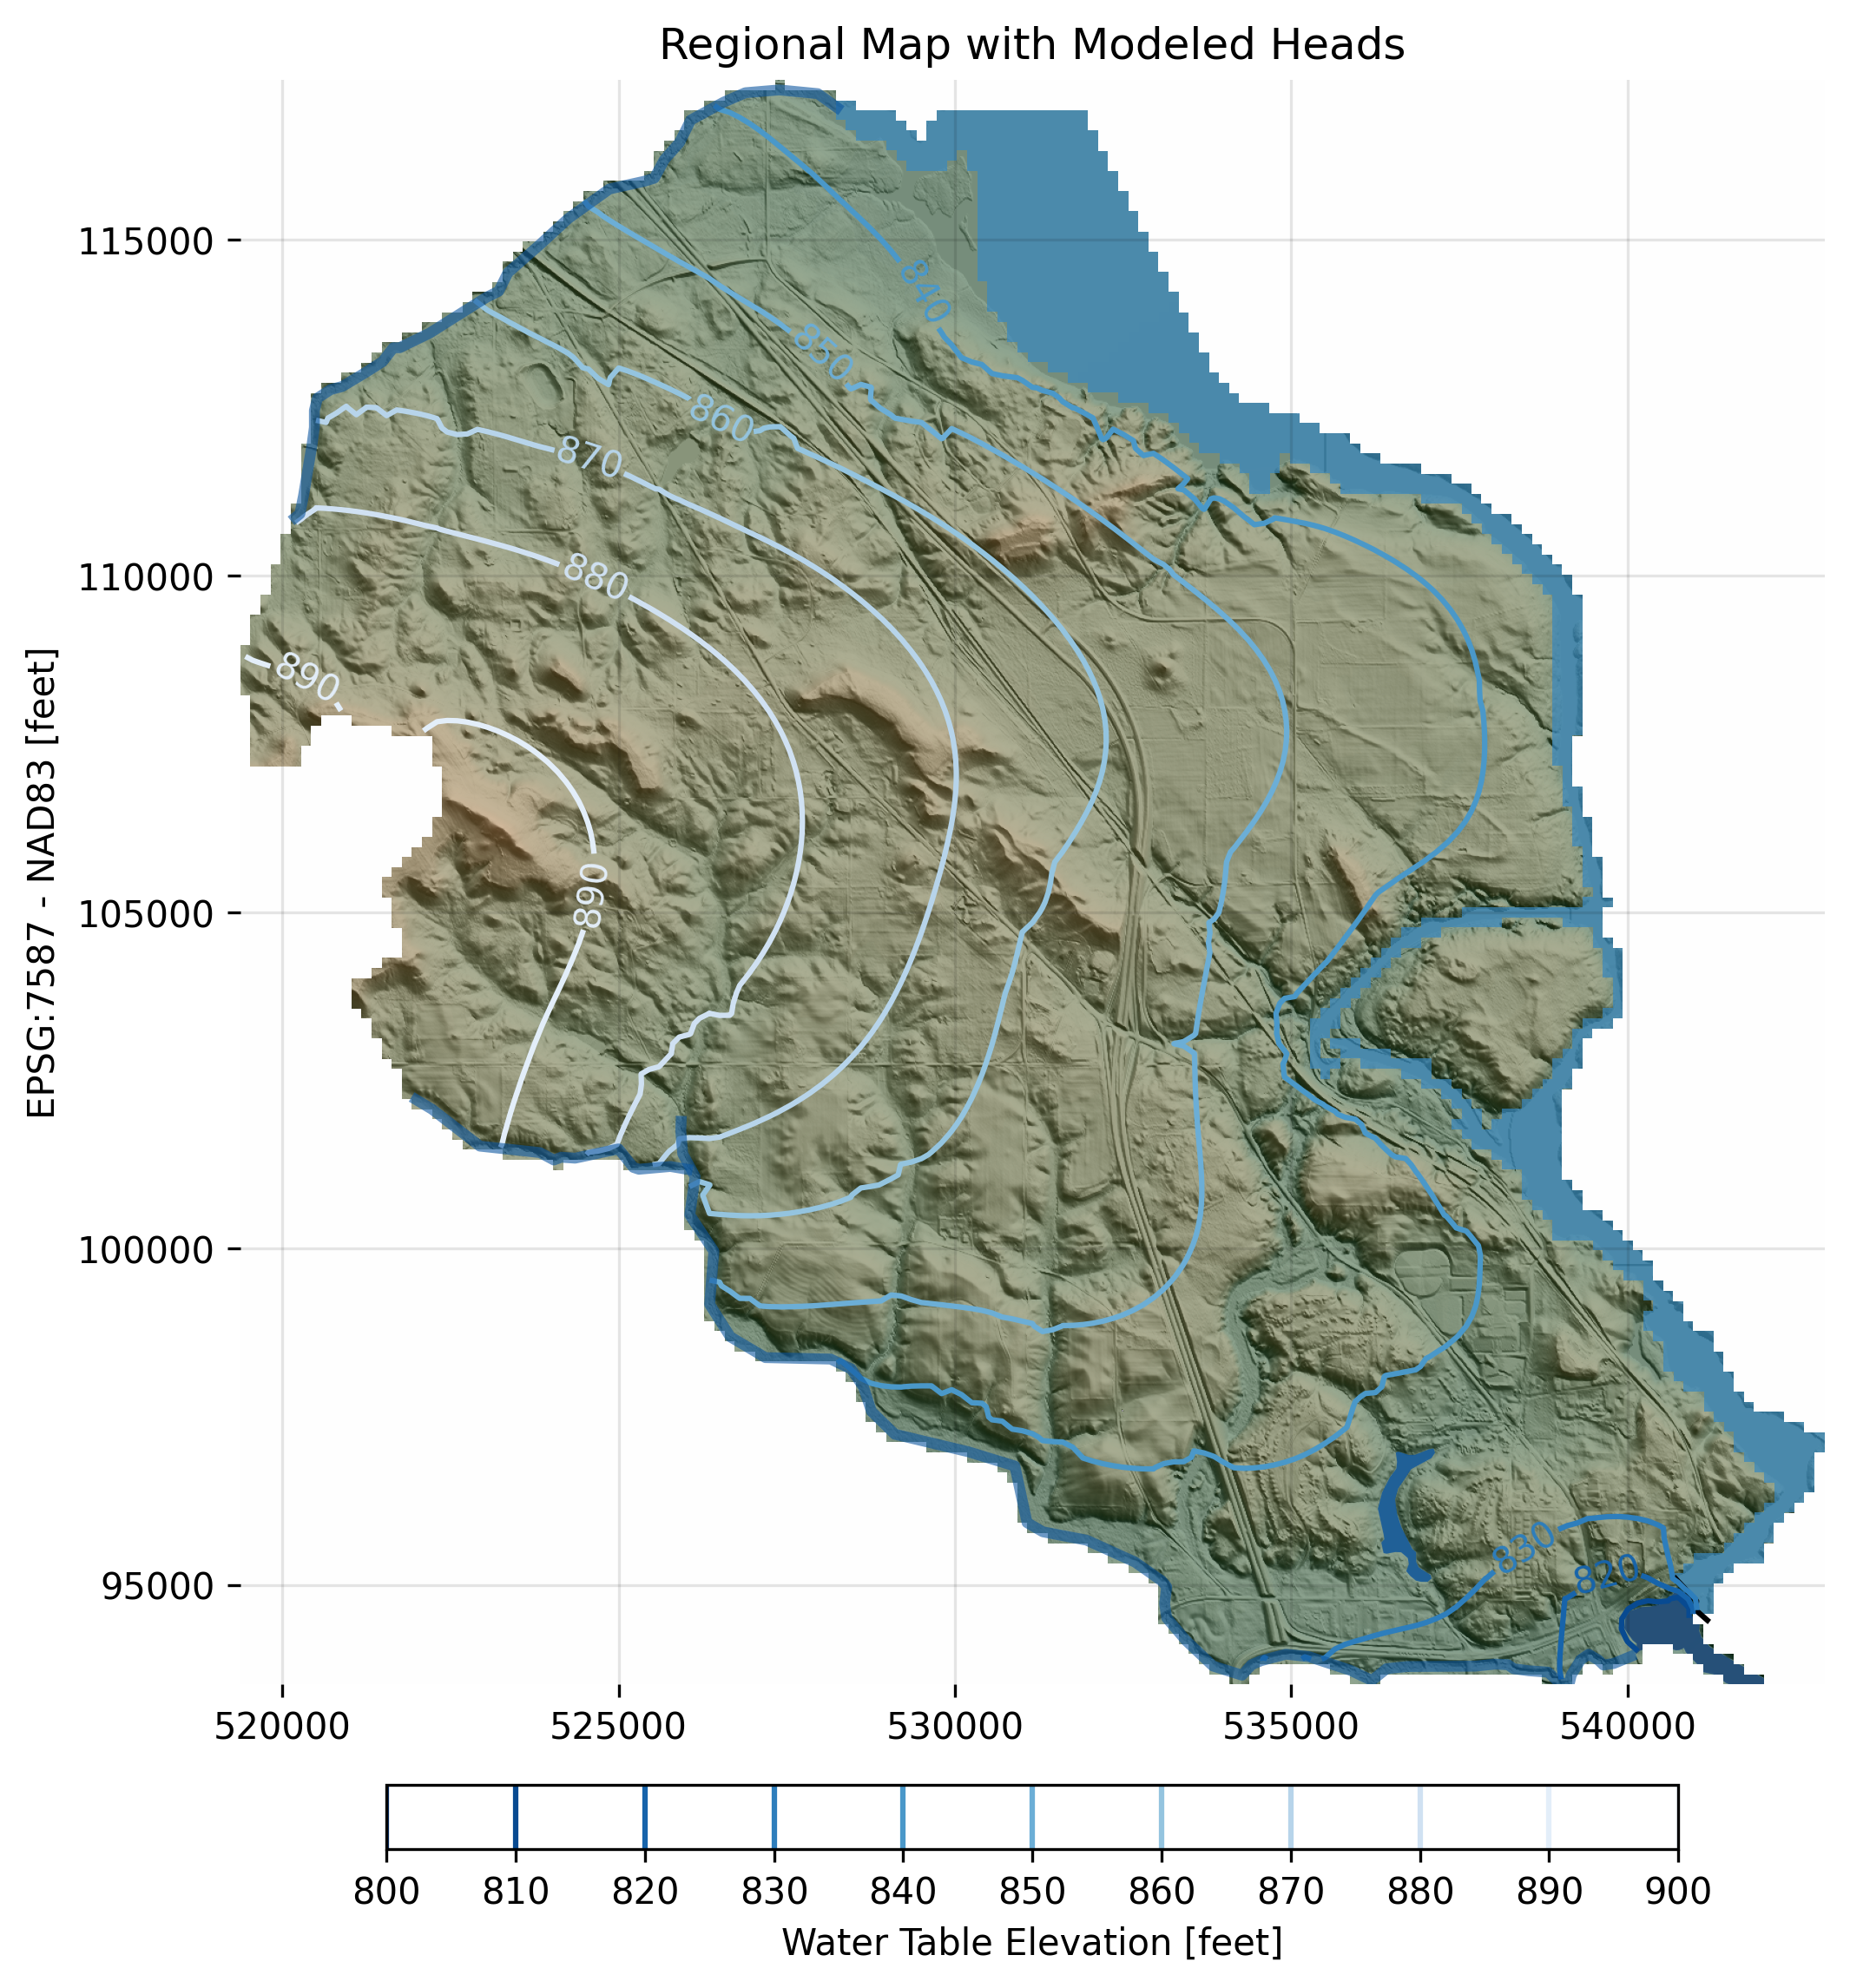

In [20]:
#visualize geospatial data
fig, ax = plt.subplots(figsize = (8,10), dpi=300)

rioplot.show(hillshade_masked, transform=hillshade_dataset.transform, ax=ax, cmap = "Greys_r")
rioplot.show(dem_masked, transform=dem_dataset.transform, ax=ax, cmap = cm.fes, alpha=0.5, vmin=200, vmax=1400)


noflow.plot(ax=ax,color='k')

# WCRs.plot(ax=ax, color = "yellow", edgecolor = 'k', markersize = 15, lw = 0.2)
pmv = flopy.plot.PlotMapView(model=gwf_ss, ax = ax, layer = 0)


# Plot water table contours
levels = np.arange(800, 910, 10)
pmv_ts = pmv.contour_array(wtr_tbl, cmap = 'Blues_r', levels=levels, alpha = 1)
ax.clabel(pmv_ts, inline=True, fontsize=10)


# plot interpolated DEM
# plt.imshow(topp, extent=pgrid.extent, cmap = cm.fes, alpha=0.9, vmin=200, vmax=1400)
# Plot north river interpolation
plt.imshow(river_interp, extent=pgrid.extent, cmap = 'Blues_r', alpha=0.70, vmin=levels.min(), vmax=levels.max())

# plot other constant head boundaries (on same colorscale)
bluecolors = plt.cm.Blues_r(np.arange(0, levels.max() - levels.min() ,1))
so_river.plot(ax=ax, color=bluecolors[round(mean_stg_so)-800], alpha=0.7)
lake.plot(ax=ax, color=bluecolors[round(mean_lake)-800], alpha=0.8)

# plot drains
streams.plot(ax=ax, color=bluecolors[round(mean_stg_no)-800], lw=3, alpha=0.6)

# Show model outline
# pmv.plot_array(gwf_ss.dis.idomain.array[0], masked_values=[1], cmap=cm.broc_r, alpha=0.99)
pmv.plot_array(gwf_ss.dis.idomain.array[0], masked_values=[1], cmap=cm.grayC_r, alpha=0.99)


plt.colorbar(pmv_ts, label = "Water Table Elevation [feet]", ticks=levels, shrink = 0.8, pad =0.05, orientation = 'horizontal')

ax.set_title("Regional Map with Modeled Heads")
# ax.set_xlabel("EPSG:7587 - NAD83 [feet]")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.grid(axis='x', color='k', alpha=0.1)
plt.grid(axis='y', color='k', alpha=0.1)
ax.set_ylabel("EPSG:7587 - NAD83 [feet]")

# plt.savefig('model_output_regional_map.pdf')
plt.show()

## Code for importing simulation in order to add or edit models

In [76]:
# Set up path to model output folder
sim_name = 'ss_flow8'
model_dir = os.path.join(outdir, sim_name)

#import simulation
sim_wct = flopy.mf6.MFSimulation.load(sim_name, exe_name=os.path.join(exe_loc, 'mf6.exe'), sim_ws=model_dir)
sim_wct.check()
print(sim_wct)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package chd...
    loading package npf...
    loading package rch...
    loading package drn...
    loading package oc...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package rch...
    loading package oc...
  loading exchange package gwf-gwf_exg_0...
  loading solution package parent...
Checking model "parent"...

parent MODEL DATA VALIDATION SUMMARY:
  No errors or warnings encountered.

  Checks that passed:
    .chd package: BC indices valid
    .chd package: not a number (Nan) entries
    .chd package: BC in inactive cells
    npf package: zero or negative horizontal hydraulic conductivity values
    npf package: vertical hydraulic conductivity values below checker threshold of 1e-11
    npf package: vertical hydraulic conductivity values abov

In [77]:
def add_transport_model(sim, lgr, topc, cdepths, porosity, alpha, source_cells, solute_mass_flux): 
    # start timer to measure how fast the model runs
    tic = time.perf_counter()
    
    # load SS flow model
    gwf = sim.get_model("parent")
    # load ss child model
    gwfc = sim.get_model("child") #groundwater flow model
    # Extract heads
    heads = gwfc.output.head().get_alldata()
    depth2water = topc - heads[-1, -1, :,:]

     # TRANSPORT
    gwt_name = 'child_transport'
    gwt = flopy.mf6.MFModel(sim, model_type='gwt6',
                            modelname=gwt_name)
    
       #lgr information
    cnlay, cnrow, cncol = lgr.get_shape()
    cdelr, cdelc = lgr.get_delr_delc()
    cibound = lgr.get_idomain()
    xorigin, yorigin = lgr.get_lower_left()
    
    length_units = gwf.dis.length_units.data

    # Now define the bottom of each layer
    botmc = []
    ccumdepths = np.cumsum(cdepths)
    
    for lay in range(cnlay):
        layer = topc - ccumdepths[lay]
        botmc.append(layer)
    botmc = np.asarray(botmc)  

    disgwt = flopy.mf6.ModflowGwtdis(gwt, length_units=length_units,
                                     nlay=cnlay, nrow=cnrow, ncol=cncol,
                                     delr=cdelr, delc=cdelc,
                                     top=topc, botm=botmc, idomain=cibound,
                                       xorigin=xorigin, yorigin=yorigin)

    # IMS      
    imsgwt = flopy.mf6.ModflowIms(sim,
                                  print_option='SUMMARY',
                                  complexity='COMPLEX',
                                  outer_maximum=200,
                                  inner_maximum=100,
                                  pname='imsgwt',
                                  filename=f"{gwt_name}.ims")
        
    sim.register_ims_package(imsgwt, [gwt.name])
    
    icgwt = flopy.mf6.ModflowGwtic(gwt, strt=0.0)

    # find the cells at the source zone
    src_pd = {}
    # source rate cells
    src = []
    src_zero = []  # New list for the second dictionary entry
    
    for (j, i) in source_cells:
        lay_idx = np.argmax(ccumdepths> depth2water[j,i])
        src.append([(lay_idx, j, i), 1.1])
        src_zero.append([(lay_idx, j, i), 0])  # Adding the same cells but with 0 value
    
    src_pd[0] = src
    # second stress period sets fluxes to zero
    src_pd[1] = src_zero 

    #source package
    srcgwt = flopy.mf6.ModflowGwtsrc(gwt, stress_period_data=src_pd)

    # ADV
    advgwt = flopy.mf6.ModflowGwtadv(gwt,
                                     scheme='TVD',
                                     pname='adv')

    # MST
    mstgwt = flopy.mf6.ModflowGwtmst(gwt,
                                     save_flows=True,
                                     porosity=porosity,
                                     sorption = "LINEAR",
                                     bulk_density=1800, #kg/m3 
                                     distcoef=0.0, 
                                     pname='mst')

    # Test with tracer
    trpt = 0.1
    # lognitudinal dispersivity in horizontal direction
    alh = alpha #m
    ath1 = alh*trpt
    dspgwt = flopy.mf6.ModflowGwtdsp(gwt, alh=alh, ath1 =ath1)

    flopy.mf6.ModflowGwtssm(gwt)

    # Instantiating MODFLOW 6 transport output control package
    flopy.mf6.ModflowGwtoc(gwt,
            budget_filerecord=f"{gwt_name}.cbc",
            concentration_filerecord=f"{gwt_name}.ucn",
            # concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
            saverecord=[("CONCENTRATION", "ALL"), ("BUDGET", "ALL")],
            printrecord=[("CONCENTRATION", "ALL"), ("BUDGET", "ALL")])

    # Instantiating MODFLOW 6 flow-transport exchange mechanism
    flopy.mf6.ModflowGwfgwt(sim,
            exgtype="GWF6-GWT6",
            exgmnamea='child', exgmnameb=gwt_name,
            filename=f"{sim_name}.gwfgwt")

    print("Child transport model created")
    
    return sim

In [78]:
por = 0.2
alpha = 1
solute_mass_flux = 0.2 # kg/day?

sim_wct = add_transport_model(sim_wct, lgr, topc, cdepths, por, alpha, source_cells, solute_mass_flux)

Child transport model created


In [79]:
sim_wct.write_simulation(silent=True)
sim_wct.run_simulation(silent=False)

FloPy is using the following executable to run the model: C:\Hydro\mf6.4.2\mf6.4.2_win64\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.2 06/28/2023

   MODFLOW 6 compiled Jun 28 2023 18:41:13 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor t

(True, [])

## Now extract model output and make a pretty plot!

In [141]:
gwt = sim_wct.get_model("child_transport")
# Extract concentration data
conc = gwt.output.concentration().get_alldata() # get_data() retrieves only the last timestep
times = gwt.output.concentration().get_times()

gwfc = sim_wct.get_model("child") #groundwater flow model
# Extract heads
child_heads = gwfc.output.head().get_alldata()
child_wtr_tbl = get_water_table(child_heads)

print(times)

[365.0]


In [142]:
# Threshold the lower bound of concentrations to plot
c_threshold = 0.0001
masked_conc = np.ma.masked_where(conc < c_threshold, conc)
masked_conc = np.ma.masked_where(masked_conc > 1e10, masked_conc)
print(masked_conc.shape)

(1, 9, 490, 400)


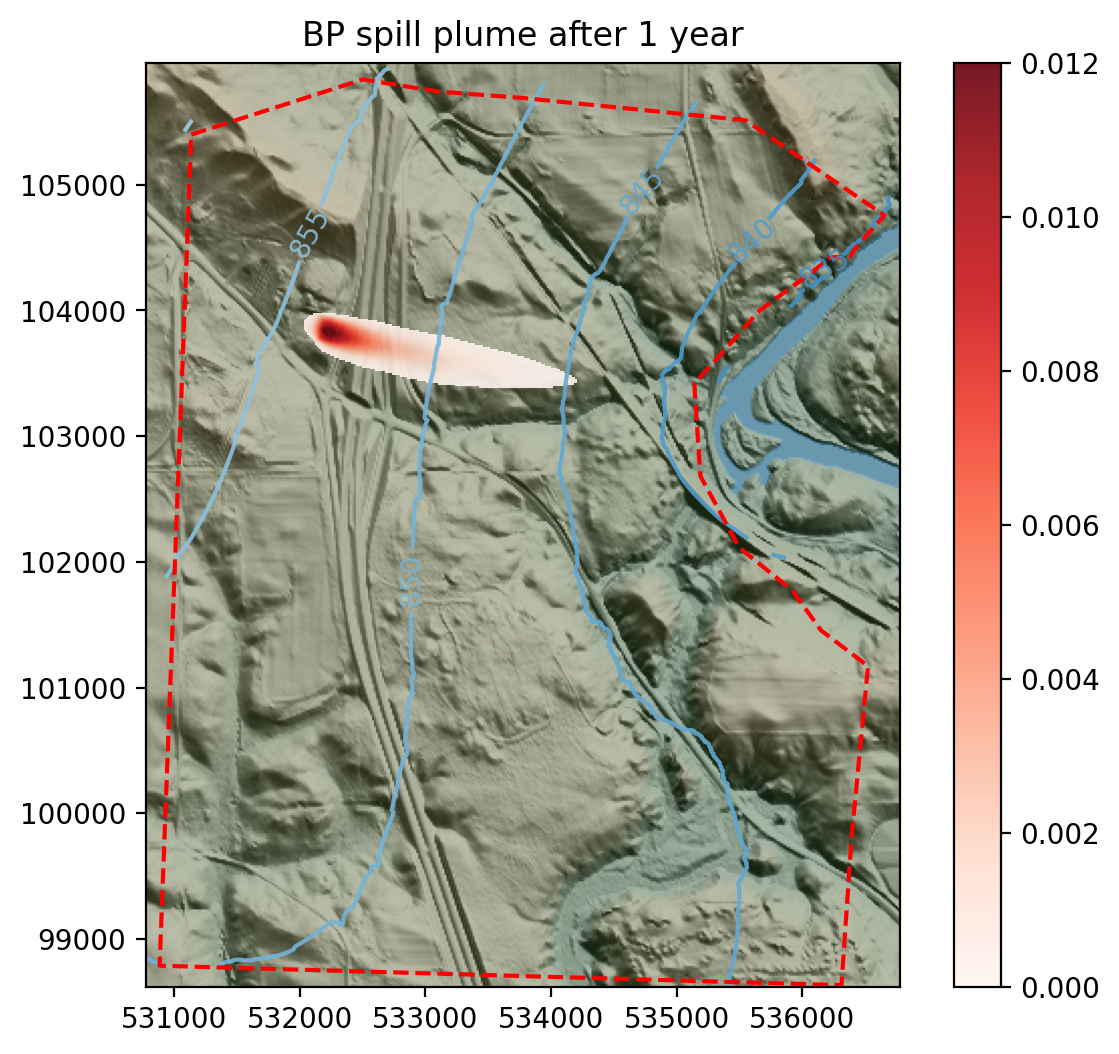

In [147]:
## Plot child grid
fig, ax = plt.subplots(figsize=(7, 6), dpi=200)
# plot interpolated DEM
rioplot.show(hillshade_masked, transform=hillshade_dataset.transform, ax=ax, cmap = "Greys_r")
plt.imshow(topc, extent=cgrid.extent, cmap = cm.fes, alpha=0.4, vmin=200, vmax=1400)

# plot water table contours
levels = np.arange(800, 900, 5)
pmv = flopy.plot.PlotMapView(model=gwfc, ax = ax, layer = 0)
pmv_ts = pmv.contour_array(child_wtr_tbl, cmap = 'Blues_r', levels=levels, alpha = 0.9)
ax.clabel(pmv_ts, inline=True, fontsize=10)

# plot concentration field
plt.imshow(masked_conc[0,7,:,:], extent=cgrid.extent, cmap = 'Reds', alpha=0.9, vmin=0.000, vmax=0.012)
plt.title('BP spill plume after 1 year')
plt.colorbar()

# add river
no_river.plot(ax=ax,color='dodgerblue', alpha=0.3)

# Plot model boundaries
nearfield.boundary.plot(ax=ax, ls='--', color='red')

# ax.set_xlim(cgrid.extent[0], cgrid.extent[1])
# ax.set_ylim(cgrid.extent[2], cgrid.extent[3])

plt.show()

In [31]:
print(conc.shape)

(1, 9, 490, 400)


## Tune recharge and hydraulic conductivity of regional model 

In [45]:
sim_name = 'tuned_model'
RE = np.arange(7, 18, 1) /12/365 # (Ft/Day) 12 inches per year based on Columbia county survey map https://wgnhs.wisc.edu/pubshare/WOFR2012-02.pdf
nre = len(RE)
# print(RE)
# In the future it might be nice to incorporate SWB model of recharge https://www.usgs.gov/centers/upper-midwest-water-science-center/science/soil-water-balance-swb-a-modified-thornthwaite
HK = np.arange(1, 20, 1) 
nhk = len(HK)
# print(HK)
hk_iter = hk
# preallocate SAE matrix
SAE = np.zeros((nre, nhk))
for ir in range(nre):
    # loop through recharge
    recharge_iter = RE[ir]
    for ih in range(nhk):
        # Loop through hk 
        hk_iter[1] = HK[ih]
        print('hk = ' + str(hk_iter) + ', recharge = ' + str(recharge_iter))
        
        # Call model function
        sim_ss = NWT_Mf6(sim_name, exe_loc, outdir, pgrid, delvp, bounds, no_river_cells, so_river_cells, lake_cells, stream_cells,
            strt_head, river_interp, topp, recharge_iter, hk_iter, perlen)      #general steady-state model inputs

        # Write and run model
        sim_ss.write_simulation(silent=True)
        sim_ss.run_simulation(silent=True)

        # Extract model output
        gwf_ss = sim_ss.get_model(sim_ss.model_names[0]) #groundwater flow model
        # Extract heads
        head = gwf_ss.output.head().get_alldata()
        # get the water table
        wtr_tbl = get_water_table(head)
        # index cells for comparison with WRCs
        model_obs = wtr_tbl[obs_cells[:,0], obs_cells[:,1]]
        residuals = WCRs['WaterEleva'] - model_obs
        SAE[ir, ih] = sum(abs(residuals))


hk = [50, 1], recharge = 0.0015981735159817352
building groundwater simulation--output location: D:\Dropbox\Teaching\Contaminant hydro 629\Contaminant-Hydrogeology-Activities\MF6_field_scale_model_examples\tuned_model
Done!
hk = [50, 2], recharge = 0.0015981735159817352
building groundwater simulation--output location: D:\Dropbox\Teaching\Contaminant hydro 629\Contaminant-Hydrogeology-Activities\MF6_field_scale_model_examples\tuned_model
Done!
hk = [50, 3], recharge = 0.0015981735159817352
building groundwater simulation--output location: D:\Dropbox\Teaching\Contaminant hydro 629\Contaminant-Hydrogeology-Activities\MF6_field_scale_model_examples\tuned_model
Done!
hk = [50, 4], recharge = 0.0015981735159817352
building groundwater simulation--output location: D:\Dropbox\Teaching\Contaminant hydro 629\Contaminant-Hydrogeology-Activities\MF6_field_scale_model_examples\tuned_model
Done!
hk = [50, 5], recharge = 0.0015981735159817352
building groundwater simulation--output location: D:\Drop

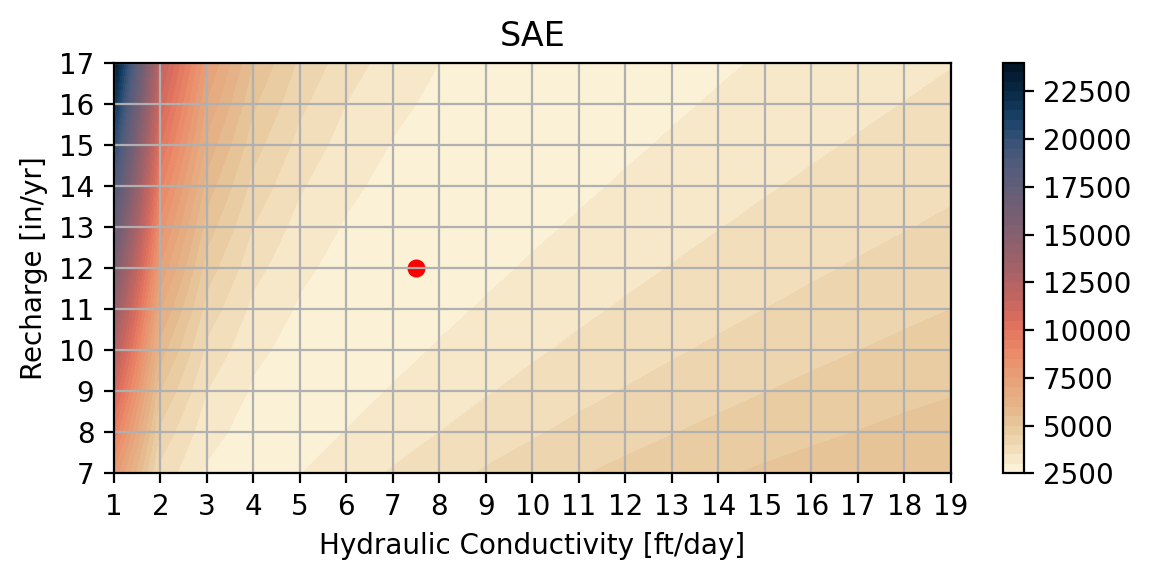

In [67]:
# Plot SAE surface
HK_grid, RE_grid = np.meshgrid(HK, RE*12*365)

fig, ax=plt.subplots(1,1, figsize = (6,3), dpi=200)
cp = ax.contourf(HK_grid, RE_grid, SAE, levels = 50, cmap=cm.lipari_r)
fig.colorbar(cp) # Add a colorbar to a plot

ax.set_yticks(RE*12*365, minor=False)
ax.yaxis.grid(True, which='major')

ax.set_xticks(HK, minor=False)
ax.xaxis.grid(True, which='major')

ax.scatter([7.5], [12], 30, 'r')

ax.set_title('SAE')
ax.set_xlabel('Hydraulic Conductivity [ft/day]')
ax.set_ylabel('Recharge [in/yr]')
plt.tight_layout()
# plt.savefig('SAE.png')
plt.show()